# Common neighbor bias, the first
One feature of connectivity commonly found in local microcircuits is a "common neighbor bias". This comes in two parts:
1. Pairs of neurons have more "common neighbors" than expected by chance.
2. The probability that a pair of neuron is connected depends on the number of common neighbors between them

First of all, what is a common neighbor? Consider the connection graph of the local circuit, with neurons as nodes and synaptic connections between them as edges. A common neighbor of two nodes A and B is a node that is adjacent to both of them. In a directed network (such as a neural circuit), we can further distinguish several types of common neighbors:
1. A common postsynaptic neighbor of two neurons A and B is a neuron innervated by both of them. (Indicated in red in the image below)
2. A common presynaptic neighbor of two neurons is a neuron innervating both of them. (Indicated in green in the image below)
3. A general common neighbor is a neuron innervating or being innervated by both of them. (Indicated in blue in the image below)

![Sketch_CN.png](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/Sketch_CN.png)

Perin et al., 2011 repeatedly sampled up to eight neurons of a local circuit and detected the connections between them. Analyzing the data, they found more common neighbors between them than expected by chance.

![CN1](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN1.png)

In the model microcircuit we can perform a similar analysis, but instead of considering only a hand full of neurons at a time, we can look at all of them simultaneously, for a more global picture.
In this exercise, we will only analyze postsynaptic neighbors; we leave it to the interested reader to adapt it for presynaptic or general common neighbors.

We begin by importing relevant packages, loading a Circuit, and defining a sampled population of excitatory neurons to perform the analysis on.

In [ ]:
import numpy
import json
import numpy as np

from scipy import sparse
from scipy.stats import hypergeom
from scipy import spatial

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from bluepysnap import Circuit

In [2]:
circuit_path = '/home/data-bbp/20191017/circuit_config.json'
circuit = Circuit(circuit_path)
cells = circuit.nodes["hippocampus_neurons"]
conn = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical"]

analyze_population = 'Excitatory'
n_smpl = 2500
analyze_gids = cells.ids(analyze_population, sample=n_smpl)  # get the identifiers of target neurons
print(len(analyze_gids))

2500


Next, these analyses are most easily performed on connection matrices. That is, a matrix with one entry for each pair of neurons in the population. The entry at i,j is 1 if a connection from neuron i to neuron j exists.

So let's start with the code to extract a connection matrix from a model microcircuit. We will represent the matrix as a scipy.sparse matrix, because connectivity is very sparse.

In [3]:
def efferent_con_mat(pop_gids):
    '''Returns a sparse matrix of the EFFERENT connectivity of neurons in
    the specified population'''
    shape = (len(pop_gids), cells.size) # The output shape is (number of neurons in population x number of neurons in circuit)
    post = [conn.efferent_nodes(_g) for _g in pop_gids]  # Get identifiers of connected neurons
    
    '''prepare the sparse matrix representation, where the column indices for row i are stored in
    "indices[indptr[i]:indptr[i+1]]" and their corresponding values are stored in "data[indptr[i]:indptr[i+1]]".'''
    indptr = numpy.hstack((0, numpy.cumsum(list(map(len, post)))))
    indices = numpy.hstack(post)
    data = numpy.ones_like(indices, dtype=bool) # Simple boolean connection matrix. A connection exists or not.
    return sparse.csr_matrix((data, indices, indptr), shape=shape)

#For this example, we will look at connectivity and common neighbors between L5_MC neurons.
connections = efferent_con_mat(analyze_gids)

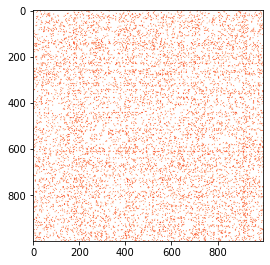

In [4]:
# Let's look at the result
vmin = np.min(connections) + 0.01   # +0.01 to avoid log(0) inside the plot
vmax = np.max(connections)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.imshow(connections.toarray()[:1000, 9000:10000], cmap='Reds', norm=LogNorm(vmin=vmin, vmax=vmax))

We see that the connectivity is indeed relatively sparse.

Now, given a connection matrix. How do we calculate the numbers of common neighbors between neurons? For each row, an entry is 1 if a given neuron is connected to the neuron represented by the row. If an entry is 1 in two different rows, then it is a common neighbor of the two neurons represented by the rows. Consequently, the inner product of two row, i.e. the sum of their elementwise product is the number of common neighbors. That means, we can get the full matrix of common neighbors simply as the product of the connection matrix with its transpose!

In [ ]:
def common_efferent_neighbors(M):
    CN = M.astype(int) * M.astype(int).transpose() # need to convert to int, so that neighbors are counted
    return CN.toarray()

com_neighs = common_efferent_neighbors(connections)
vmin = np.min(com_neighs) + 0.01   # +0.01 to avoid log(0) inside the plot
vmax = np.max(com_neighs)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.imshow(com_neighs, cmap='Reds', norm=LogNorm(vmin=vmin, vmax=vmax));

In [51]:
connections.shape

(2500, 18198)

In [55]:
len(np.where(connections.sum(axis=0)>0)[0])

18192

In [46]:
com_neighs.shape

(2500, 2500)

Note the very large entries along the main diagonal. They correspond to the product of a row with itself, yielding simply the number of neurons innervated by the neuron represented by the row. Do not mistake these entries for actual common neighbor numbers!

Now, let us generate a histogram of the number of common neighbors of neuron pairs.

In [151]:
def cn_mat_to_histogram(CN, bins):
    '''limit to upper triangular matrix. This excludes the diagonal entries and redundant entries, because the common
    neighbor matrix is always symmetrical!
    '''
    return numpy.histogram(numpy.triu(CN, 1), bins=bins)[0]

xbins = numpy.arange(502) # count from 0 to 500 common neighbors
H = cn_mat_to_histogram(com_neighs, xbins)

In [20]:
H[:120]

array([4053476,  338884,  250040,  208601,  182378,  159422,  140131,
        122087,  107318,   92826,   79694,   69191,   59830,   51754,
         44774,   38446,   33139,   28585,   24979,   21729,   18542,
         15739,   14011,   11919,   10499,    9206,    7770,    6798,
          5945,    5254,    4452,    3927,    3519,    3024,    2735,
          2304,    2006,    1791,    1623,    1401,    1143,    1028,
           974,     858,     729,     615,     586,     538,     481,
           371,     318,     301,     275,     266,     198,     177,
           177,     150,     126,     104,      93,      89,      67,
            71,      71,      62,      40,      50,      36,      31,
            26,      23,      25,      23,      21,      13,      10,
             7,      16,       8,       2,       5,       3,       8,
             6,       2,       2,       4,       5,       1,       2,
             3,       1,       1,       0,       0,       2,       1,
             0,     

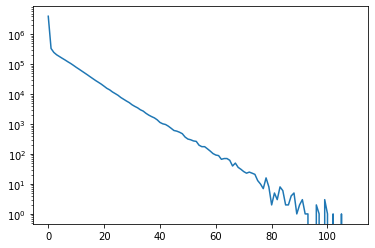

In [24]:
plt.plot(H[:110])
plt.yscale('log')

In [41]:
H[100:].sum()

3

In [36]:
H.nonzero()[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  96,  97,  99, 100, 102, 105])

As mentioned above, all of this is the number of efferent neighbors. 

### Exercise 1: Calculate the numbers of common afferent neighbors between the sampled neurons
Use the following cell to that effect and answer the following questions:
#### 1a: What is the highest number of common afferent neighbors between the sampled neurons.
Assign the answer to a variable called _ans\_1a_.

#### 1b: How many pairs of neurons (of the sampled population) have more than 100 common afferent neighbors
Make sure to not count pairs twice, i.e. exclude redundant parts. Assign the answer to a variable called _ans\_1b_.

In [102]:
adj_afferent = np.zeros((cells.count(),len(pop_gids)))

In [104]:
pre = [conn.afferent_nodes(post_gid) for post_gid in pop_gids]

In [111]:
for i,pre_to_i in enumerate(pre):
    adj_afferent[pre_to_i,i] = 1

In [119]:
adj_afferent.shape

(18198, 2500)

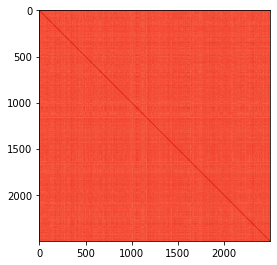

In [158]:
com_neighs_pre = adj_afferent.T.dot(adj_afferent)
vmin = np.min(com_neighs) + 0.01   # +0.01 to avoid log(0) inside the plot
vmax = np.max(com_neighs)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.imshow(com_neighs_pre, cmap='Reds', norm=LogNorm(vmin=vmin, vmax=vmax));

In [123]:
vmax

698.0

In [159]:
com_neighs_pre.shape

(2500, 2500)

In [124]:
xbins = numpy.arange(700) # count from 0 to 500 common neighbors
H_pre = cn_mat_to_histogram(com_neighs, xbins)

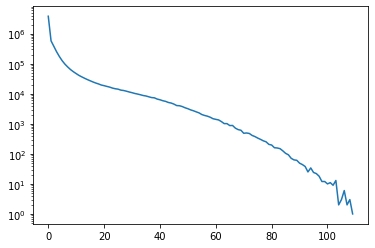

In [130]:
plt.plot(H_pre[:110])
plt.yscale('log')

In [135]:
ans_1a = H_pre.nonzero()[0][-1]

In [136]:
ans_1b = H_pre[100:].sum()

hypergeomWhat should we compare the result to? As a first, naive approach let's compare the the expected number in an Erdos-Renyi network of the same size and the same distribution of out-degrees. In that control model, given a neuron A with an out-degree d_A and a neuron B with an out-degree the number of common neighbors between them is described by the hypergeometrical distribution hypergeom(N, d_A, d_B), where N is the number of neurons in the network.

For this control, it is handy that we know the out-degrees of the neurons (entries along the main diagonal of the common neighbor matrix).

Text(0, 0.5, 'Pairs')

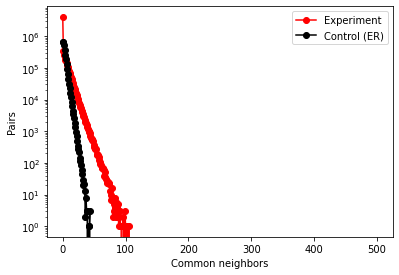

In [56]:
def control_erdos_renyi_histogram(CN, N, bins):
    out_degrees = numpy.diag(CN)
    '''Note: Here, we simply draw a random sample for each pair of neurons.
    Better, but more expensive would be to evaluate the probability mass function
    for all bins and for all pairs.'''
    expected = [hypergeom(N, d_A, out_degrees[(i+1):]).rvs()
                for i, d_A in enumerate(out_degrees)]
    return numpy.histogram(numpy.hstack(expected), bins=bins)[0]

H_ctrl_er = control_erdos_renyi_histogram(com_neighs, connections.shape[1], xbins)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(xbins[:-1], H, color='red', marker='o', label='Experiment')
ax.plot(xbins[:-1], H_ctrl_er, color='black', marker='o', label='Control (ER)')
ax.set_yscale('log'); ax.legend(); ax.set_xlabel('Common neighbors'); ax.set_ylabel('Pairs')


In [59]:
H_ctrl_er.shape

(501,)

Wow, that is a gigantic difference! At first glance much stronger than Perin et al., 2011 found.
To assess the significance, let's do some very basic statistics

As an exercise let's do a bit of toy statistics.
### Exercise 2: What is the probability of finding the observed common neighbor numbers in the Erdos-renyi control?
#### 2a: How many pairs of neurons (of the sampled population) have more than 100 common efferent neighbors in the modeled hippocampal microcircuit?
Assign the answer to a variable called _ans\_2a_.
#### 2b: What is the expected number of pairs of neurons with more than 100 common efferent neighbors in the Erdos-renyi control?
Evaluate the cumulative distribution of common neighbor numbers for all pairs in the control model to answer. Assign the answer to a variable called _ans\_2b_.

In [138]:
# Work here
H[100:].sum()

3

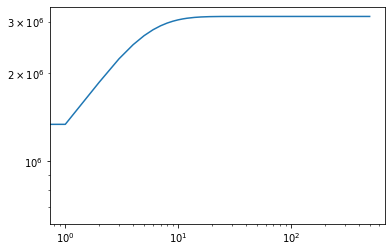

In [144]:
plt.plot(np.cumsum(H_ctrl_er))
plt.xscale('log')
plt.yscale('log')

In [145]:
ans_2a = H[100:].sum()
ans_2b = np.cumsum(H_ctrl_er)

Can we explain the observed difference between model and control? Well, let us remember what else we know about neuron connectivity in local circuits. We know from an earlier exercise that it is highly distance-dependent.

That means, if two neurons are close to each other, they are more likely to be connected. And a trio of neurons that is close to each other is very likely to form a motif where one is the common neighbor of the other two. But the naive ER control does not take that into account. All the control sees is that the average connectivity, sampled across small and large distances alike is very sparse, and thus common neighbors are expected to be very uncommon. (The interested reader can try to prove analytically that a distance dependent network has more common neighbors than an ER network of equal size and sparsity. It is not very hard if you assume exponential distance dependence).

Why was the Perin et al. result not affected so strongly? Because they sampled neuron populations at always roughly the same distance (~150 um), while we looked at all pairs at all distances.

So, as a better control, let us compare to a network with the same distance dependence of connectivity.
First, we generate such a control.

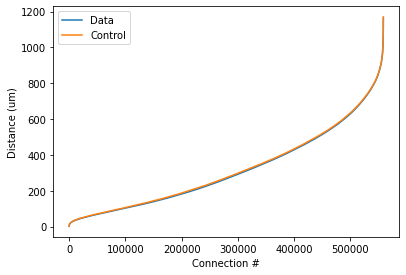

In [146]:
nbins = 50

def connect_keep_dist_dep(D, C, nbins):
    '''Randomly connect a number of neurons, keeping their distance dependence intact.
    D: Matrix (AxN) of distances to all other neurons in the circuit
    C: Matrix (AxN) of connections to all other neurons in the circuit (boolean)'''
    dbins = numpy.linspace(0, D.max(), nbins + 1) + 0.1
    Di = numpy.digitize(D, bins=dbins) - 1
    H_connected = numpy.histogram(Di[C.toarray()], bins=range(nbins + 1))[0]
    H_all = numpy.histogram(Di, bins=range(nbins + 1))[0]
    P = H_connected.astype(float) / H_all
    n_eff = numpy.array(C.sum(axis=1)).transpose()[0]
    indptr = [0]
    indices = []
    for row, n in zip(Di, n_eff):
        p_row = P[row]
        p_row[row == -1] = 0
        p_row = p_row / p_row.sum()
        rnd = numpy.random.choice(len(row), n, replace=False, p=p_row)
        indices.extend(rnd)
        indptr.append(indptr[-1] + n)
    data = numpy.ones_like(indices, dtype=bool)
    return sparse.csr_matrix((data, indices, indptr), shape=D.shape)

xyz = cells.positions()
# get distance matrix as an input
D = spatial.distance_matrix(xyz.loc[analyze_gids], xyz)

# generate random instance
rnd_connections = connect_keep_dist_dep(D, connections, nbins)

# compare distribution of distances of connected neurons
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(sorted(D[connections.toarray()]), label='Data')
ax.plot(sorted(D[rnd_connections.toarray()]), label='Control')
ax.legend(); ax.set_xlabel('Connection #'); ax.set_ylabel('Distance (um)');

In [229]:
D.min()

0.0

As we can see, the random control preserves the distance dependence (strictly we have shown: It preserves the cumulative distribution of distances of connected neuron pairs). And indeed, it even preserves the out-degrees of all individual neurons. This is a much more powerful control than the ER control earlier. 
Now let's see the common neighbor distributrion.

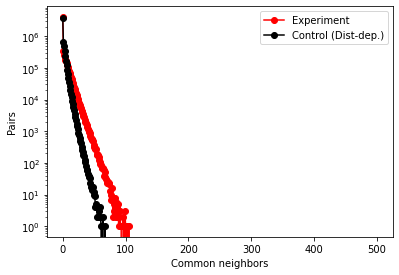

In [152]:
rnd_com_neighs = common_efferent_neighbors(rnd_connections)
rnd_H = cn_mat_to_histogram(rnd_com_neighs, xbins)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(xbins[:-1], H, color='red', marker='o', label='Experiment')
ax.plot(xbins[:-1], rnd_H, color='black', marker='o', label='Control (Dist-dep.)')
ax.set_yscale('log'); ax.legend(); ax.set_xlabel('Common neighbors'); ax.set_ylabel('Pairs');

We still see a very strong difference, although indeed weaker than for the naive ER control. The presence of a clearly significant difference in spite of the strong control (preserving both out-degrees of all individual neurons and the distance-dependence) indicates the presence of a clear bias for an increased number of common neighbors.

Let's measure the strength of the bias as in Reimann et al., 2017: The normalized difference in slope of linear fits of the logarithm of the distributions. (Although in that paper we used the average of 10 random controls instead of just 1).
Note: This analysis is stable against subsampling because the calculation is performed in log-space. Subsampling only affects the expected value of the offset, not of the slope.

In [153]:
def cn_bias_1(H_data, H_ctrl):
    assert len(H_data) == len(H_ctrl)
    log_data = numpy.log10(H_data[1:]) # exclude the bin at 0
    log_ctrl = numpy.log10(H_ctrl[1:])
    idx_data = numpy.nonzero(~numpy.isinf(log_data))[0] # exclude zero bins
    idx_ctrl = numpy.nonzero(~numpy.isinf(log_ctrl))[0]
    slope_data = numpy.polyfit(idx_data.astype(float), log_data[idx_data], 1)[0]
    slope_ctrl = numpy.polyfit(idx_ctrl.astype(float), log_ctrl[idx_ctrl], 1)[0]
    return (slope_ctrl - slope_data) / slope_ctrl

print(cn_bias_1(H, rnd_H))

0.36723646561146217


/tmp/ipykernel_56/1972356776.py:3: RuntimeWarning: divide by zero encountered in log10
  log_data = numpy.log10(H_data[1:]) # exclude the bin at 0
/tmp/ipykernel_56/1972356776.py:4: RuntimeWarning: divide by zero encountered in log10
  log_ctrl = numpy.log10(H_ctrl[1:])


As before, let's do the same analysis for afferent common neighbors as an exercise.
### Exercise 3: Calculate the afferent common neigbor bias
#### 3a: Calculate a control network that preserves the distance dependence and the in-degree of every individual neuron. How many pairs in this control have more than 100 common afferent neighbors?
That is: Preserve in-degree instead of out-degree for this control. As the result is stochastic, you have to only approximately get it right. Assign the answer to a variable _ans\_3a_.
#### 3b: What is the strength of the bias for an increased number of common afferent neighbors between the sampled neurons?
That is, cn_bias_1, but for afferent bias and comparing to the control preserving in-degree. Assign the answer to a variable _ans\_3b_.

In [ ]:
# Work here

In [156]:
D.shape

(2500, 18198)

In [157]:
connections.shape

(2500, 18198)

In [161]:
adj_afferent.shape

(18198, 2500)

In [163]:
adj_afferent_sparse = sparse.csr_matrix(adj_afferent)

In [169]:
C = connections
'''Randomly connect a number of neurons, keeping their distance dependence intact.
D: Matrix (AxN) of distances to all other neurons in the circuit
C: Matrix (AxN) of connections to all other neurons in the circuit (boolean)'''
dbins = numpy.linspace(0, D.max(), nbins + 1) + 0.1
Di = numpy.digitize(D, bins=dbins) - 1
H_connected = numpy.histogram(Di[C.toarray()], bins=range(nbins + 1))[0]
H_all = numpy.histogram(Di, bins=range(nbins + 1))[0]
P = H_connected.astype(float) / H_all
n_eff = numpy.array(C.sum(axis=1)).transpose()[0]
indptr = [0]
indices = []
for row, n in zip(Di, n_eff):
    p_row = P[row]
    p_row[row == -1] = 0
    p_row = p_row / p_row.sum()
    rnd = numpy.random.choice(len(row), n, replace=False, p=p_row)
    indices.extend(rnd)
    indptr.append(indptr[-1] + n)
data = numpy.ones_like(indices, dtype=bool)
dd_model = sparse.csr_matrix((data, indices, indptr), shape=D.shape)


In [184]:
C.toarray()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [186]:
n_eff.shape

(2500,)

In [188]:
numpy.array(C.sum(axis=1)).transpose().shape

(1, 2500)

In [175]:
D.shape

(2500, 18198)

In [177]:
Di.shape

(2500, 18198)

In [180]:
H_connected

array([ 4731, 22522, 34602, 37302, 35922, 32412, 29260, 26314, 23975,
       22328, 21142, 20477, 20069, 19261, 18776, 17508, 16648, 15493,
       14908, 13874, 12934, 12084, 10914,  9849,  9039,  8171,  7220,
        6682,  6118,  5394,  4834,  4139,  3482,  2666,  2215,  1691,
        1220,   831,   533,   346,   263,   138,    73,    35,    16,
           9,     0,     0,     0,     0])

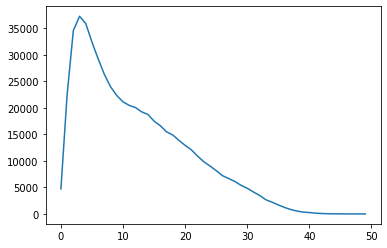

In [181]:
plt.plot(H_connected)

In [182]:
H_all

array([  41007,  216561,  397789,  537893,  666324,  785645,  896116,
        998203, 1092974, 1178011, 1258656, 1329996, 1390272, 1443953,
       1487194, 1525041, 1560967, 1586327, 1600983, 1611163, 1605034,
       1596048, 1574086, 1541182, 1505544, 1462462, 1414068, 1352586,
       1282587, 1217875, 1141663, 1061076,  977558,  903978,  838242,
        772614,  702529,  626763,  548543,  467638,  379845,  294362,
        213076,  149569,  104741,   69416,   44626,   26500,   11708,
          1506])

In [183]:
P

array([0.11537055, 0.10399841, 0.08698581, 0.06934836, 0.05391071,
       0.04125527, 0.03265202, 0.02636137, 0.02193556, 0.01895398,
       0.01679728, 0.01539629, 0.0144353 , 0.01333908, 0.01262512,
       0.01148035, 0.01066518, 0.00976659, 0.00931178, 0.00861117,
       0.0080584 , 0.0075712 , 0.00693355, 0.00639055, 0.00600381,
       0.00558715, 0.00510584, 0.00494017, 0.00477005, 0.00442903,
       0.00423417, 0.00390076, 0.00356194, 0.00294919, 0.00264244,
       0.00218867, 0.00173658, 0.00132586, 0.00097166, 0.00073989,
       0.00069239, 0.00046881, 0.0003426 , 0.00023401, 0.00015276,
       0.00012965, 0.        , 0.        , 0.        , 0.        ])

In [193]:
adj_afferent_sparse.dtype

dtype('float64')

In [197]:
# generate random instance

def connect_keep_dist_dep_pre(D, C, nbins):
    '''Randomly connect a number of neurons, keeping their distance dependence intact.
    D: Matrix (AxN) of distances to all other neurons in the circuit
    C: Matrix (AxN) of connections to all other neurons in the circuit (boolean)'''
    dbins = numpy.linspace(0, D.max(), nbins + 1) + 0.1
    Di = numpy.digitize(D, bins=dbins) - 1
    Di = Di.T # to make it afferent in for loop later
    H_connected = numpy.histogram(Di[C.toarray()], bins=range(nbins + 1))[0]
    H_all = numpy.histogram(Di, bins=range(nbins + 1))[0]
    P = H_connected.astype(float) / H_all
    n_aff = numpy.array(C.sum(axis=0)).transpose()[:,0]
    indptr = [0]
    indices = []
    for row, n in zip(Di, n_aff):
        p_row = P[row]
        p_row[row == -1] = 0
        p_row = p_row / p_row.sum()
        rnd = numpy.random.choice(len(row), n, replace=False, p=p_row)
        indices.extend(rnd)
        indptr.append(indptr[-1] + n)
    data = numpy.ones_like(indices, dtype=bool)
    return sparse.csr_matrix((data, indices, indptr), shape=D.shape)


rnd_connections_pre = connect_keep_dist_dep(D, connections, nbins)

In [ ]:
rnd_connections_pre = connect_keep_dist_dep_pre(D, connections, nbins)

In [214]:
n_aff = numpy.array(C.sum(axis=0)).transpose()[:,0]

In [215]:
n_aff

array([  0,   0,   0, ..., 104, 111, 196])

In [218]:
n_aff.shape

(18198,)

In [217]:
n_eff.shape

(2500,)

In [219]:
n_eff

array([ 53, 211, 197, ..., 209, 298, 153])

In [220]:
for row, n in zip(Di, n_aff):
    print(row,n)
    break

[26 34 32 ... 33  9 14] 0


In [222]:
indptr = [0]
indices = []
for row, n in zip(Di, n_eff):
    p_row = P[row]
    p_row[row == -1] = 0 # set probs to zero where digitized value corr to -1 i.e. no connection
    p_row = p_row / p_row.sum() 
    rnd = numpy.random.choice(len(row), n, replace=False, p=p_row)
    indices.extend(rnd)
    indptr.append(indptr[-1] + n)
    break

In [231]:
p_row[row == -1]

array([0.])

In [232]:
p_row

array([2.55507601e-05, 1.32233421e-05, 1.78247380e-05, ...,
       1.47583976e-05, 9.48500140e-05, 6.31789456e-05])

In [230]:
Di.min()

-1

In [224]:
row.shape

(18198,)

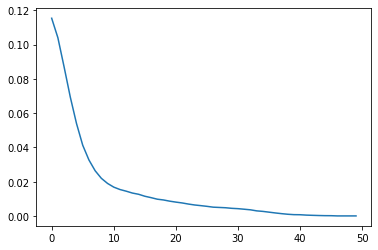

In [234]:
plt.plot(P)

In [225]:
P.shape

(50,)

In [226]:
p_row.shape

(18198,)

In [ ]:
# compare distribution of distances of connected neurons
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(sorted(D[connections.toarray()]), label='Data')
ax.plot(sorted(D[rnd_connections.toarray()]), label='Control')
ax.legend(); ax.set_xlabel('Connection #'); ax.set_ylabel('Distance (um)');

In [ ]:
# This is to generate the answers to paste in the submission box below.
# After you defined the variables with your answers, run this cell and the next cell, and copy-paste the output into the box below
print(json.dumps(dict([("ans_1a", ans_1a),
                       ("ans_1b", ans_1b),
                       ("ans_2a", ans_2a),
                       ("ans_2b", ans_2b),
                       ("ans_3a", ans_3a),
                       ("ans_3b", ans_3b)])))


In [ ]:
import single_cell_mooc_client as sc_mc
s = sc_mc.Submission()